패키지 다운로드

In [1]:
!sudo apt-get install -y python-numpy python-dev cmake zlib1g-dev libjpeg-dev xvfb \
    xorg-dev python-opengl libboost-all-dev libsdl2-dev swig
!pip install pyvirtualdisplay
!pip install piglet

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'python-dev-is-python2' instead of 'python-dev'
libjpeg-dev is already the newest version (8c-2ubuntu8).
libjpeg-dev set to manually installed.
libboost-all-dev is already the newest version (1.71.0.0ubuntu2).
cmake is already the newest version (3.16.3-1ubuntu1.20.04.1).
zlib1g-dev is already the newest version (1:1.2.11.dfsg-2ubuntu1.5).
zlib1g-dev set to manually installed.
The following package was automatically installed and is no longer required:
  libnvidia-common-510
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  freeglut3 libblkid-dev libdbus-1-dev libdmx-dev libdmx1 libdrm-dev
  libegl1-mesa-dev libffi-dev libfontenc-dev libfs-dev libfs6 libgl1-mesa-dev
  libgles-dev libgles1 libgles2-mesa-dev libglib2.0-dev libglib2.0-dev-bin
  libglvnd-dev libibus-1.0-dev libmount-dev libopengl-dev libpciaccess-dev
  libpixman-1-dev 

gym 설치

In [2]:
## gym
!pip install gym[classic_control]

##ffmpeg
!sudo apt-get install ffmpeg -y

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 58.6 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:4.2.7-0ubuntu0.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-510
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.


Video 함수

In [3]:
### import
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()
from base64 import b64encode
from glob import glob
from IPython.display import HTML
from IPython import display as ipy_display
from gym import logger as gym_logger
from gym.wrappers.record_video import RecordVideo

In [4]:
#### show video func
def show_video(mode='train', filename=None):
    mp4_list = glob(mode+'/*.mp4')
    # print(mp4_list)
    if mp4_list:
        if filename :
            file_lists = glob(mode+'/'+filename)
            if not file_lists:
                print('No {} found'.format(filename))
                return -1
            mp4 = file_lists[0]
                    
        else:
            mp4 = sorted(mp4_list)[-1]

        print(mp4)
        video = open(mp4, 'r+b').read()
        encoded = b64encode(video)
        ipy_display.display(HTML(data='''
            <video alt="gameplay" autoplay controls style="height: 400px;">
                <source src="data:video/mp4;base64,%s" type="video/mp4" />
            </video>
        ''' % (encoded.decode('ascii'))))
    else:
        print('No video found')
        return -1

In [15]:
import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model

import sys
from collections import deque
import numpy as np
import random
import gym
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import os
import warnings
warnings.filterwarnings(action='ignore')

In [6]:
#### early stopping by avg
class EarlyStopping_by_avg():
    def __init__(self, patience=10, verbose=0):
        super().__init__()

        self.best_avg = 0
        self.step = 0
        self.patience = patience
        self.verbose = verbose

    def check(self, avg , avg_scores):
        ## best avg가 나올경우
        if avg >= self.best_avg:
            self.best_avg = avg
            self.step = 0
            # print("avg_reset")
        ## 이전값보다 현재 avg가 높을경우
        elif len(avg_scores) > 1 and avg > avg_scores[-2]:  ### 이전 값과 비교해야하므로 -2  , -1은 지금 avg와 동일함
            self.step = 0
            # print("이전값보다 avg 높아서 reset")
        else:
            self.step += 1
            if self.step > self.patience:
                if self.verbose:
                    print('조기 종료')
                return True
        return False

Agent(ActorCritic)

In [13]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomUniform
from tensorflow_probability import distributions as tfd




# 정책 신경망과 가치 신경망 생성
class A2C(tf.keras.Model):
    def __init__(self, action_size):
        super(A2C, self).__init__()
        self.actor_fc = Dense(24, activation='tanh')
        self.actor_out = Dense(action_size, activation='softmax',
                               kernel_initializer=RandomUniform(-1e-3, 1e-3))
        self.critic_fc1 = Dense(24, activation='tanh')
        self.critic_fc2 = Dense(24, activation='tanh')
        self.critic_out = Dense(1,
                                kernel_initializer=RandomUniform(-1e-3, 1e-3))

    def call(self, x):
        actor_x = self.actor_fc(x)
        policy = self.actor_out(actor_x)

        critic_x = self.critic_fc1(x)
        critic_x = self.critic_fc2(critic_x)
        value = self.critic_out(critic_x)
        return policy, value

In [22]:
class ActorCritic():
    def __init__(self, state_size, action_size):
        ## 상태 및 행동 size 정의
        ## stae = 2가지 정보 , action = 3가지 정보
        self.state_size = state_size
        self.action_size = action_size

        # ActorCritic 하이퍼 파라메터
        ## carpole = 0.98  / mountain_car = 0.999
        self.discount_factor = 0.99
        self.learning_rate = 0.001

        # ActorCritic 신경망 모델 생성
        self.model = self.actor_critic_dnn()

        ## Countinuous 
        # self.max_action = max_action
        # self.model = A2C(self.action_size)
        # self.loss_fn = keras.losses.MeanSquaredError()

        # 최적화 알고리즘 설정, 미분값이 너무 커지는 현상을 막기 위해 clipnorm 설정
        self.optimizer = keras.optimizers.Adam(learning_rate = self.learning_rate, clipnorm=1.0)


    # 정책신경망으로 행동 선택
    def get_action(self, state):
        ## policy 선택
        policy , value = self.model(state)
        policy = np.array(policy[0])
        action =  np.random.choice(self.action_size, 1, p=policy)[0]
        # print(f'action : {action} , policy:{policy}')
        return action

    # # 정책신경망의 출력을 받아 확률적으로 행동을 선택
    # def get_action(self, state):
    #     mu, sigma, _ = self.model(state)
    #     dist = tfd.Normal(loc=mu[0], scale=sigma[0])
    #     action = dist.sample([1])[0]
    #     action = np.clip(action, -self.max_action, self.max_action)
    #     return action


    # Dnn 모델 생성   
    def actor_critic_dnn(self):
        ### state가 들어감
        input_ = keras.layers.Input(shape=(self.state_size))

        ### Actor (정책평가)
        actor_fc = keras.layers.Dense(64, activation='tanh')(input_)
        actor_fc = keras.layers.Dense(32, activation='tanh')(actor_fc)
        policy = keras.layers.Dense(self.action_size, activation='softmax', kernel_initializer=keras.initializers.RandomUniform(-1e-3, 1e-3))(actor_fc)

        ## Critic (가치평가)
        critic_fc1 = keras.layers.Dense(128, activation='tanh')(input_)
        critic_fc2 = keras.layers.Dense(64, activation='tanh')(critic_fc1)
        critic_fc3 = keras.layers.Dense(24, activation='tanh')(critic_fc2)
        value = keras.layers.Dense(1, kernel_initializer=keras.initializers.RandomUniform(-1e-3, 1e-3))(critic_fc3)

        ## model
        model = keras.models.Model(inputs=[input_], outputs=[policy, value])

        return model   


    # 정책신경망 업데이트
    # 각 타임스텝마다 정책신경망과 가치신경망을 업데이트
    def train_model(self, state, action, reward, next_state, done):
        model_params = self.model.trainable_variables
        with tf.GradientTape() as tape:
            policy, value = self.model(state)
            _, next_value = self.model(next_state)
            target = reward + (1 - done) * self.discount_factor * next_value[0]

            # 정책 신경망 오류 함수 구하기
            one_hot_action = tf.one_hot([action], self.action_size)
            action_prob = tf.reduce_sum(one_hot_action * policy, axis=1)
            cross_entropy = - tf.math.log(action_prob + 1e-5)
            advantage = tf.stop_gradient(target - value[0])
            actor_loss = tf.reduce_mean(cross_entropy * advantage)      

            # 가치 신경망 오류 함수 구하기
            # critic_loss = self.loss_fn( tf.stop_gradient(target) , value[0])  ### MeanSquaredError = tf.reduce_mean( tf.square )
            critic_loss = 0.5 * tf.square(tf.stop_gradient(target) -  value[0])  
            critic_loss = tf.reduce_mean(critic_loss)

            # 하나의 오류 함수로 만들기
            loss = 0.2 * actor_loss + critic_loss

        # 오류함수를 줄이는 방향으로 모델 업데이트
        grads = tape.gradient(loss, model_params)
        self.optimizer.apply_gradients(zip(grads, model_params))
        return None


        


# # 각 타임스텝마다 정책신경망과 가치신경망을 업데이트  ### Continuos 
#     def train_model(self, state, action, reward, next_state, done):
#         model_params = self.model.trainable_variables
#         with tf.GradientTape() as tape:
#             mu, sigma, value = self.model(state)
#             _, _, next_value = self.model(next_state)
#             target = reward + (1 - done) * self.discount_factor * next_value[0]

#             # 정책 신경망 오류 함수 구하기
#             advantage = tf.stop_gradient(target - value[0])
#             dist = tfd.Normal(loc=mu, scale=sigma)
#             action_prob = dist.prob([action])[0]
#             cross_entropy = - tf.math.log(action_prob + 1e-5)
#             actor_loss = tf.reduce_mean(cross_entropy * advantage)

#             # 가치 신경망 오류 함수 구하기
#             critic_loss = self.loss_fn( tf.stop_gradient(target) , value[0])

#             # 하나의 오류 함수로 만들기
#             loss = 0.1 * actor_loss + critic_loss

#         # 오류함수를 줄이는 방향으로 모델 업데이트
#         grads = tape.gradient(loss, model_params)
#         self.optimizer.apply_gradients(zip(grads, model_params))
#         return loss, 

Env(환경) - Cart Pole

episode:   0 | avg_score: nan
episode:  20 | avg_score: 35.40
episode:  40 | avg_score: 41.50
episode:  60 | avg_score: 25.10
episode:  80 | avg_score: 39.10
episode: 100 | avg_score: 90.30
episode: 120 | avg_score: 140.60
episode: 140 | avg_score: 87.10
episode: 160 | avg_score: 66.80
episode: 180 | avg_score: 47.10
episode: 200 | avg_score: 110.30
episode: 220 | avg_score: 63.90
episode: 240 | avg_score: 74.00
episode: 260 | avg_score: 66.70
episode: 280 | avg_score: 68.40
episode: 300 | avg_score: 62.60
episode: 320 | avg_score: 64.90
episode: 340 | avg_score: 58.30
episode: 360 | avg_score: 91.90
episode: 380 | avg_score: 73.80
episode: 400 | avg_score: 75.50
episode: 420 | avg_score: 74.70
episode: 440 | avg_score: 69.70
episode: 460 | avg_score: 57.90
episode: 480 | avg_score: 81.70
episode: 500 | avg_score: 44.90
episode: 520 | avg_score: 38.40
episode: 540 | avg_score: 35.70
episode: 560 | avg_score: 34.10
episode: 580 | avg_score: 49.30
episode: 600 | avg_score: 60.00
episode:

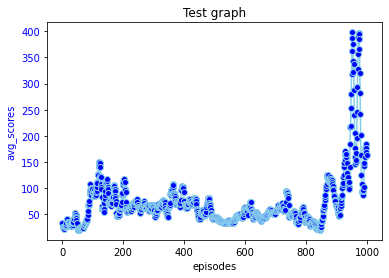

In [19]:
#### 학습 환경
# CartPole 환경 정의
ENV_NAME = 'CartPole-v1'
env = gym.make(ENV_NAME)

# 비디오 레코딩
env = RecordVideo(env, './train', episode_trigger =lambda episode_number: True )
env.metadata = {'render.modes': ['human', 'ansi']}

# CartPole 환경의 상태와 행동 크기 정의
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

## Continuous 
# action_size = env.action_space.shape[0]
# max_action = env.action_space.high[0]

load_model=False

# 위에서 정의한 DQN 클래스를 활용하여 agent 정의
agent = ActorCritic(state_size, action_size)

if load_model:
  # 위에서 정의한 DQN 클래스를 활용하여 agent 정의
  load_model = '200th'
  agent.model.load_weights(f'save_model/mountain_model/{load_model}/')

# 반복 학습 에피소드 수 정의
num_episode = 1000
early_stopping_by_avg = EarlyStopping_by_avg(patience=30, verbose=1)

## early stopping을 위한 초기값 설정 
print_interval = 20
avg_reward_episode = 0
scores, avg_scores, episodes, losses = [], [], [], []


for epoch in range(num_episode):
    # done flag와 score 값 초기화
    done = False
    score = 0
    step = 0
    rewards_list = [] 

    # 환경 reset을 통해 초기 상태 정의 --> state는 [car_position , car_velocity] 2개의 값을 받는데 
    # car_position = -0.6 ~ 0.4 사이의 값을 받으며 , car_velocity = 0 을 받음
    state = env.reset()
    # print(f'init_state : {state}')
    
    # print(f"avg: {avg_step}")
    if early_stopping_by_avg.check(avg_reward_episode , avg_scores ):
        print("earstpping 실행")
        break
      
    # print(f'epoch : {epoch}번째 수행 중')
    while not done:

        # 현재 상태에 대하여 행동 정의
        # action = agent.policy(init_state[np.newaxis,:]) ### network에 넣어 주기 위해서 기존 (2,) 배열을 (1,2)로 축을 추가함
        action = agent.get_action(np.expand_dims(state, axis=0))
        ### 위와 같은 의미 np.expand_dims(a, axis=0)
        
        next_state, reward, done, info = env.step(action)
        
        # 해당 에피소드의 최종 score를 위해 reward 값 누적  -> 환경에서 주는 reward 적산
        score += reward

        # 기본 환경은 pole이 쓰러지지 않으면 +1의 보상을 준다.
        # 자신만의 보상가설을 만들어 학습 가능
        ### 종료조건
        # 폴 각도는 ±12° 이상입니다.
        # 카트 위치가 ±2.4 이상(카트 중앙이 디스플레이 가장자리에 도달함)
        # 에피소드 길이가 200보다 큽니다.
        
        def get_reward(pos, angle , done):
            ### 위치 / 속도 조건으로 보상크게
            cond_pos = (pos < 2.0) and (pos > -2.0)
            cond_angle = (angle < 5.0) and (angle > -5.0)
            ### 상점
            if cond_pos or cond_angle:
                return 0.1
            elif cond_pos:
                return 0.2
            elif cond_pos and cond_angle:
                return 0.3
            ### 벌점
            elif (pos > 2.5) or (pos < -2.5):
                return -0.1
            elif (angle > 10.0) or (angle < -10.0):
                return -0.2
            
            
        ### position
        pos = next_state[0]
        ### velocity
        angle = next_state[2]
        reward = get_reward(pos, angle, done)  ## agent가 받는 보상설계

        # reward = 0.1 if not done or score == 500 else -1  ## agent가 받는 보상설계

        ## 매스텝 마다 신경망 업데이트
        ## 학습할때 사용할 next_state의 shape도 맞춰줌  
        ### network에 넣어 주기 위해서 기존 (2,) 배열을 (1,2)로 축을 추가함 np.expand_dims(state, axis=0)
        agent.train_model(np.expand_dims(state, axis=0), action, reward, np.expand_dims(next_state, axis=0), done)

        # 다음 상태를 현재 상태로 정의
        state = next_state
                    
        if done:            
             ### early stop
            avg_step = np.mean(scores[-10:])


            # 에피소드 종료마다 결과 그래프 저장
            scores.append(score)
            avg_scores.append(avg_step)
            episodes.append(epoch)

            
            # 에피소드 종료마다 결과 출력
            if epoch % print_interval == 0:
              print(f'episode: {epoch:3d} | avg_score: { avg_step :3.2f}')

            # 100 에피소드마다 모델 저장
            if epoch % 500 == 0:
               agent.model.save_weights(f'save_model/cartpole_model/{epoch}th/', save_format='tf')

            # 이동 평균이 400 이상일 때 종료
            if avg_step > 400:
               agent.model.save_weights(f'save_model/cartpole_model/final/', save_format='tf')
               sys.exit()
            

env.close()

plt.title('Test graph')
plt.xlabel('episodes')

plt.plot(episodes, avg_scores,
         color='skyblue',
         marker='o', markerfacecolor='blue',
         markersize=6)
plt.ylabel('avg_scores', color='blue')
plt.tick_params(axis='y', labelcolor='blue')

plt.savefig('cartpole_graph.png')
plt.show()

In [20]:
### max episode
### nan이 젤 큰값이므로 이값을제거하고 계산함
avg_scores_fil = [x for x in avg_scores if np.isnan(x) !=True]
episode=np.argmax(avg_scores_fil)
# episode=88
filename = 'rl-video-episode-{}.mp4'.format(episode)
print("최대 avg : {} ,에피소드 번호 : {}".format(max(avg_scores_fil) , episode))
show_video(filename=filename)

최대 avg : 397.9 ,에피소드 번호 : 951
train/rl-video-episode-951.mp4


Env(환경)  -  Mountain Car

In [24]:
#### 학습 환경
# CartPole 환경 정의
ENV_NAME = 'MountainCar-v0'
# ENV_NAME = 'MountainCarContinuous-v0'
env = gym.make(ENV_NAME)

# 비디오 레코딩
env = RecordVideo(env, './train', episode_trigger =lambda episode_number: True )
env.metadata = {'render.modes': ['human', 'ansi']}

# CartPole 환경의 상태와 행동 크기 정의
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
# action_size = env.action_space.shape[0]

# max_action = env.action_space.high[0]

load_model=False

# 위에서 정의한 DQN 클래스를 활용하여 agent 정의
agent = ActorCritic(state_size, action_size)

if load_model:
  # 위에서 정의한 DQN 클래스를 활용하여 agent 정의
  load_model = '200th'
  agent.model.load_weights(f'save_model/mountain_model/{load_model}/')

scores, avg_scores, episodes ,avg_rewards  = [], [], [], [] 

# 반복 학습 에피소드 수 정의
num_episode = 500
early_stopping_by_avg = EarlyStopping_by_avg(patience=30, verbose=1)

## early stopping을 위한 초기값 설정 
avg_reward_episode = 0
success = 0
max_position = -0.4
print_interval = 1

scores, episodes = [], []

for epoch in range(num_episode):
    # done flag와 score 값 초기화
    done = False
    score = 0
    step = 0
    rewards_list = [] 

    # 환경 reset을 통해 초기 상태 정의 --> state는 [car_position , car_velocity] 2개의 값을 받는데 
    # car_position = -0.6 ~ 0.4 사이의 값을 받으며 , car_velocity = 0 을 받음
    state = env.reset()
    # print(f'init_state : {state}')
    
    # print(f"avg: {avg_step}")
    if early_stopping_by_avg.check(avg_reward_episode , avg_scores ):
        print("earstpping 실행")
        break
      
    # print(f'epoch : {epoch}번째 수행 중')
    while not done:

        # 현재 상태에 대하여 행동 정의
        # action = agent.policy(init_state[np.newaxis,:]) ### network에 넣어 주기 위해서 기존 (2,) 배열을 (1,2)로 축을 추가함
        action = agent.get_action(np.expand_dims(state, axis=0))
        ### 위와 같은 의미 np.expand_dims(a, axis=0)
        
        # env.step 함수를 이용하여 행동에 대한 다음 상태, 보상, done flag 등 획득
        ### return ex) nex_state=[-0.57330334 -0.00063329]
        ###            reward=-1.0
        ###            done=False
        ###            info={}
        next_state, reward, done, info = env.step(action)
        


        ### reward 설계
        #### 목표는 가능한 한 빨리 오른쪽 언덕 위에 놓인 깃발에 도달하는 것이므로 에이전트는 각 타임스텝에 대해 -1의 보상으로 페널티를 받습니다.
        #### 다음 중 하나가 발생하면 에피소드가 종료됩니다.

        ###종료: 자동차의 위치가 0.5보다 크거나 같습니다(오른쪽 언덕 위의 목표 위치).
        ###잘림: 에피소드 길이는 200입니다.

        ### reward 설계
        #### 목표는 가능한 한 빨리 오른쪽 언덕 위에 놓인 깃발에 도달하는 것이므로 에이전트는 각 타임스텝에 대해 -1의 보상으로 페널티를 받습니다.
        #### 다음 중 하나가 발생하면 에피소드가 종료됩니다.

        ###종료: 자동차의 위치가 0.5보다 크거나 같습니다(오른쪽 언덕 위의 목표 위치).
        ###잘림: 에피소드 길이는 200입니다.
        reward=0.1 if not done else -1
        
        ### position에 따라서 action이 맞으면 reward를 줌
        car_pos = next_state[0]
        car_vel = next_state[1]

        # def get_reward(car_pos, car_vel,max_position,step):
          ## 2차함수로 만들어 속도가 커지게 더큰 리워드를 위치에 따라 받게함
        if car_vel > 0:
          reward = float(((car_pos+0.5)*20)**2/10+15*car_vel) 
        else:
          reward = float(((car_pos+0.5)*20)**2/10) 

          ### max position   
        if car_pos > max_position:
          ## max position
          max_position = car_pos 

          ## 성공 시 success
        if car_pos >= 0.5:
           reward=100
           success +=1
  
        else:
          score -= 1  

        step += 1


        # print(f'reward : {reward}')

        # 획득된 상태, 행동, 보상, 다음상태, done flag를 리플레이 버퍼에 축적
        rewards_list.append(reward)

        ## 매스텝 마다 신경망 업데이트
        ## 학습할때 사용할 next_state의 shape도 맞춰줌  
        ### network에 넣어 주기 위해서 기존 (2,) 배열을 (1,2)로 축을 추가함 np.expand_dims(state, axis=0)
        agent.train_model(np.expand_dims(state, axis=0), action, reward, np.expand_dims(next_state, axis=0), done)

        # 다음 상태를 현재 상태로 정의
        state = next_state
                    
        if done:            
            ### early stop
            avg_score_episode = np.mean(scores[-10:])
            avg_reward_episode = np.mean(rewards_list)


            # 에피소드 종료마다 결과 그래프 저장
            #### reward --> 매 스텝에서 받은 reward의 양 ( state에서 알맞는 action을 많이 할 수록 reward가 커짐)
            avg_rewards.append(avg_reward_episode)


            #### score --> 환경에서 reward는 매 step마다 -1 감소 인데, 200 step이 되면 종료되므로, -200 보다 커질수록 높은 score

            scores.append(score)
            avg_scores.append(avg_score_episode)
            episodes.append(epoch)

            
            # 에피소드 종료마다 결과 출력
            if epoch % print_interval == 0:
               print(f'episode: {epoch:3d} | success: {success} | car_pos_max : {max_position : .3f} | avg_reward : {avg_reward_episode : .3f} | score_avg : {avg_score_episode : .3f} |  step : {step} ')
            
            # 100 에피소드마다 모델 저장
            if epoch % 200 == 0 or epoch % num_episode == 0:
               agent.model.save_weights(f'save_model/mountain_model/{epoch}th/', save_format='tf')
               print("model 저장 ")

env.close()

        
plt.title('Test graph')
plt.xlabel('episodes')

plt.plot(episodes, avg_scores,
         color='skyblue',
         marker='o', markerfacecolor='blue',
         markersize=6)
plt.ylabel('avg_scores', color='blue')
plt.tick_params(axis='y', labelcolor='blue')
plt.savefig('cartpole_graph.png')
plt.show()

episode:   0 | success: 0 | car_pos_max : -0.400 | avg_reward :  0.268 | score_avg :  nan |  step : 200 
model 저장 
episode:   1 | success: 0 | car_pos_max : -0.318 | avg_reward :  0.793 | score_avg : -200.000 |  step : 200 
episode:   2 | success: 0 | car_pos_max : -0.318 | avg_reward :  0.666 | score_avg : -200.000 |  step : 200 
episode:   3 | success: 0 | car_pos_max : -0.264 | avg_reward :  1.049 | score_avg : -200.000 |  step : 200 
episode:   4 | success: 0 | car_pos_max : -0.264 | avg_reward :  0.391 | score_avg : -200.000 |  step : 200 
episode:   5 | success: 0 | car_pos_max : -0.264 | avg_reward :  0.380 | score_avg : -200.000 |  step : 200 
episode:   6 | success: 0 | car_pos_max : -0.264 | avg_reward :  0.160 | score_avg : -200.000 |  step : 200 
episode:   7 | success: 0 | car_pos_max : -0.264 | avg_reward :  0.398 | score_avg : -200.000 |  step : 200 
episode:   8 | success: 0 | car_pos_max : -0.264 | avg_reward :  0.465 | score_avg : -200.000 |  step : 200 
episode:   9 

KeyboardInterrupt: ignored

In [25]:
### max episode
### nan이 젤 큰값이므로 이값을제거하고 계산함
avg_scores_fil = [x for x in avg_scores if np.isnan(x) !=True]
episode=np.argmax(avg_scores_fil)
# episode=88
filename = 'rl-video-episode-{}.mp4'.format(episode)
print("최대 avg : {} ,에피소드 번호 : {}".format(max(avg_scores_fil) , episode))
show_video(filename=filename)

최대 avg : -200.0 ,에피소드 번호 : 0
train/rl-video-episode-0.mp4
